# 📈 VolSense — Data Preparation & Feature Engineering

This notebook demonstrates the **complete preprocessing pipeline** for VolSense:

- Fetching OHLCV data using `yfinance`
- Building multi-ticker datasets using `volsense_core.data_fetching.multi_fetch`
- Generating realized volatility and engineered features via `feature_engineering.py`

You’ll end up with a clean, feature-rich dataset ready for model training or inference.

In [10]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from volsense_core.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
from volsense_core.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_core.data_fetching.feature_engineering import build_features

## ⚙️ Step 1: Define parameters
We’ll specify:
- Ticker universe
- Date range
- Rolling window length for realized volatility calculation

In [4]:
TICKERS = ["AAPL", "MSFT", "SPY", "NVDA", "META"]
START_DATE = "2015-01-01"
LOOKBACK = 15  # rolling days for realized volatility (15 is the default for pretrained models)

## 🧩 Step 2: Fetch data for a single ticker

The `fetch_ohlcv()` utility wraps around `yfinance` and ensures standardized columns.  
Let’s start with **AAPL** as an example.

In [3]:
df_aapl = fetch_ohlcv("AAPL", start=START_DATE)
print(df_aapl.head())

        date       open       high        low      close  adj_close     volume
0 2015-01-02  27.847500  27.860001  26.837500  27.332500  24.261044  212818400
1 2015-01-05  27.072500  27.162500  26.352501  26.562500  23.577576  257142000
2 2015-01-06  26.635000  26.857500  26.157499  26.565001  23.579792  263188400
3 2015-01-07  26.799999  27.049999  26.674999  26.937500  23.910437  160423600
4 2015-01-08  27.307501  28.037500  27.174999  27.972500  24.829123  237458000


## 📊 Step 3: Compute returns and realized volatility

`compute_returns_vol()` adds:
- daily returns (`return`)
- realized volatility (`realized_vol`)  
based on a rolling window (default 21 days, or the `lookback` you specify).

In [4]:
df_aapl = compute_returns_vol(df_aapl, window=LOOKBACK, ticker="AAPL")
df_aapl.head(10)

,date,return,realized_vol,ticker
15,2015-01-26,0.001063,0.308933,AAPL
16,2015-01-27,-0.035013,0.322127,AAPL
17,2015-01-28,0.056533,0.391716,AAPL
18,2015-01-29,0.031134,0.404301,AAPL
19,2015-01-30,-0.014634,0.387965,AAPL
20,2015-02-02,0.012546,0.389600,AAPL
21,2015-02-03,0.000169,0.369386,AAPL
22,2015-02-04,0.007670,0.369236,AAPL
23,2015-02-05,0.007137,0.366886,AAPL
24,2015-02-06,-0.008421,0.343334,AAPL


## 📈 Step 4: Visualize realized volatility
This quick check ensures the rolling volatility looks reasonable.

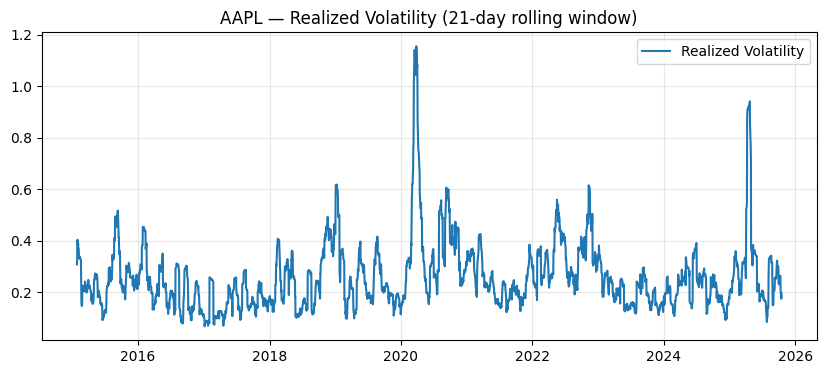

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df_aapl["date"], df_aapl["realized_vol"], label="Realized Volatility")
plt.title("AAPL — Realized Volatility (21-day rolling window)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🌍 Step 5: Fetch data for multiple tickers

We’ll now pull OHLCV data for the entire universe at once  
using `fetch_multi_ohlcv()`. This function returns a dictionary of DataFrames.

In [5]:
multi_dict = fetch_multi_ohlcv(TICKERS, start=START_DATE)
for tkr, df in multi_dict.items():
    print(f"{tkr}: {len(df)} rows")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

AAPL: 2715 rows
MSFT: 2715 rows
SPY: 2715 rows
NVDA: 2715 rows
META: 2715 rows


## 🧱 Step 6: Build combined multi-ticker dataset

`build_multi_dataset()` merges all ticker DataFrames into a **single standardized table**  
with columns: `['date', 'return', 'realized_vol', 'ticker']`

In [6]:
multi_df = build_multi_dataset(multi_dict, lookback=LOOKBACK)
multi_df.head()

,date,return,realized_vol,ticker
0,2015-01-26,0.001062,0.308933,AAPL
1,2015-01-27,-0.035013,0.322125,AAPL
2,2015-01-28,0.056533,0.391714,AAPL
3,2015-01-29,0.031133,0.404299,AAPL
4,2015-01-30,-0.014634,0.387962,AAPL


## 🧠 Step 7: Generate advanced features

`generate_features()` adds all derived metrics used by the models, such as:
- Rolling volatilities (`vol_3d`, `vol_10d`, `vol_ratio`, etc.)
- Market stress and skewness features
- Calendar encodings (`month_sin`, `month_cos`, `day_of_week`)
- EWMA and volatility of volatility measures

`realized_log_vol` is usually set as the target column, to assist with better generalization for model training.

In [7]:
multi_df = build_features(multi_df)
multi_df.head()

,return,realized_vol_log,ticker,realized_vol,date,vol_vol,vol_ratio,skew_5d,market_stress_1d_lag,abs_return,month_sin,vol_3d,ret_sq,day_of_week,ewma_vol_10d,market_stress,vol_chg,vol_10d,month_cos
0,0.001062,-1.174629,AAPL,0.308933,2015-01-26,NaN,0.999997,NaN,NaN,0.001062,0.5,0.308933,0.000001,0.000000,0.308933,0.003202,0.000000,0.308933,0.866025
1,-0.035013,-1.132811,AAPL,0.322125,2015-01-27,0.009329,0.999997,NaN,0.003202,0.035013,0.5,0.315529,0.001226,0.166667,0.311331,0.031067,0.000000,0.315529,0.866025
2,0.056533,-0.937220,AAPL,0.391714,2015-01-28,0.044478,0.999997,0.252503,0.031067,0.056533,0.5,0.340924,0.003196,0.333333,0.325946,0.034822,0.000000,0.340924,0.866025
3,0.031133,-0.905599,AAPL,0.404299,2015-01-29,0.048197,1.044690,-0.187517,0.034822,0.031133,0.5,0.372713,0.000969,0.500000,0.340192,0.008002,0.015945,0.356768,0.866025
4,-0.014634,-0.946845,AAPL,0.387962,2015-01-30,0.044009,1.087190,0.220791,0.008002,0.014634,0.5,0.394659,0.000214,0.666667,0.348878,0.010713,0.031652,0.363007,0.866025


## 🧾 Step 8: Inspect available features
Let’s verify all the generated columns now present in the dataset.

In [8]:
print("Feature columns:")
print([col for col in multi_df.columns if col not in ["ticker", "date"]])

Feature columns:
['return', 'realized_vol_log', 'realized_vol', 'vol_vol', 'vol_ratio', 'skew_5d', 'market_stress_1d_lag', 'abs_return', 'month_sin', 'vol_3d', 'ret_sq', 'day_of_week', 'ewma_vol_10d', 'market_stress', 'vol_chg', 'vol_10d', 'month_cos']


## 🔍 Step 9: Visualize a feature — e.g. 3-day vs 10-day volatility

This helps confirm feature dynamics and sanity-check the rolling window logic.

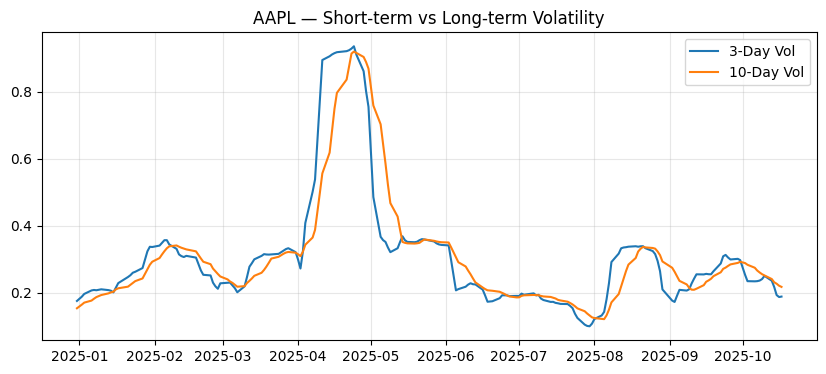

In [9]:
sample = multi_df[multi_df["ticker"] == "AAPL"].tail(200)
plt.figure(figsize=(10,4))
plt.plot(sample["date"], sample["vol_3d"], label="3-Day Vol")
plt.plot(sample["date"], sample["vol_10d"], label="10-Day Vol")
plt.title("AAPL — Short-term vs Long-term Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 💾 Step 10: Save processed dataset

We’ll store the processed DataFrame in `data/processed/`  
so it can be reused in model training and inference notebooks.

In [ ]:
os.makedirs("../data/processed", exist_ok=True)
multi_df.to_csv("../data/processed/global_volatility_dataset.csv", index=False)
print("✅ Saved processed dataset to ../data/processed/global_volatility_dataset.csv")

# ✅ Summary

We have successfully:

- Pulled OHLCV data for multiple tickers  
- Computed returns and realized volatility  
- Generated an extensive set of volatility-related features  
- Saved a clean, consolidated dataset for downstream modeling

Next → [2_model_training.ipynb](./2_model_training.ipynb)